In [1]:
import pandas as pd
import wandb

# Initialize wandb
wandb.init(project="does-not-matter")

# Fetch runs from your project
api = wandb.Api()
runs = api.runs("multi_reward_feedback_final_lul")

# Create a list to store data from filtered runs
filtered_run_data = []

# Iterate through the runs
for run in runs:
    # Check if the run name starts with "ppo_"
    if run.name.startswith("ppo_") or run.name.startswith("sac_") and "noise" in run.name:
        # Get the summary statistics (includes final values of metrics)
        summary = run.summary._json_dict

        # Get the history (includes all logged metrics)
        history = run.history(keys=["trainer/global_step", "val_loss"])

        # Combine summary and history data
        run_data = {
            "run_id": run.id,
            "run_name": run.name,
            **summary,
            **{f"{k}_history": v.tolist() for k, v in history.items()}
        }

        filtered_run_data.append(run_data)

# Create a DataFrame from filtered run data
df = pd.DataFrame(filtered_run_data)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ymetz. Use `wandb login --relogin` to force relogin


In [13]:
import colorsys
from collections import OrderedDict, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Existing color scale
color_scale = OrderedDict([
    ('evaluative', '#1f77b4'),     # blue
    ('comparative', '#ff7f0e'),    # orange
    ('demonstrative', '#2ca02c'),  # green
    ('corrective', '#d62728'),     # red
    ('descriptive', '#9467bd'),    # purple
    ('descriptive_preference', '#e377c2'),  # pink
])

# Function to create color variations
def create_color_variations(base_color, num_variations=5):
    rgb = plt.matplotlib.colors.to_rgb(base_color)
    hsv = colorsys.rgb_to_hsv(*rgb)
    colors = []
    for i in range(num_variations):
        s = max(0.25, hsv[1] * (1 - i * 0.25))
        v = min(1.0, hsv[2] * (1 + i * 0.25))
        colors.append(colorsys.hsv_to_rgb(hsv[0], s, v))
    return colors

# Function to extract environment, feedback type, and noise level from run name
def extract_info(run_name):
    parts = run_name.split('_')
    env = parts[1]
    
    # Handle the special case of "descriptive_preference"
    if "descriptive_preference" in run_name:
        feedback = "descriptive_preference"
        noise = parts[-1] if parts[-2] == "noise" else "0.0"
    else:
        feedback = parts[3]
        noise = parts[-1] if parts[-2] == "noise" else "0.0"

    return env, feedback, float(noise)

# Function to interpolate NaN values in a series
def interpolate_nans(series):
    return pd.Series(series).interpolate().ffill().bfill().values

# Group runs by environment, feedback type, and noise level
grouped_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for _, row in df.iterrows():
    env, feedback, noise = extract_info(row['run_name'])
    if isinstance(row['val_loss_history'], float):
        continue
    row['val_loss_history'] = [np.nan if x == "nan" else x for x in row['val_loss_history']]
    row['val_loss_history'] = interpolate_nans(row['val_loss_history'])
    grouped_runs[env][feedback][noise].append(row)

# Plotting function
def plot_environment(env, feedback_runs):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    #fig.suptitle(f"Reward Model: Validation Loss Curves for {env}", fontsize=16)
    
    feedback_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference"]
    noise_levels = [0.0, 0.1, 0.25, 0.5, 0.75]
    
    for idx, feedback in enumerate(feedback_types):
        
        ax = axes[idx // 3, idx % 3]
        base_color = color_scale[feedback]
        color_variations = create_color_variations(base_color)
        
        for noise, color in zip(noise_levels, color_variations):
            if noise not in feedback_runs[feedback]:
                continue
            
            runs = feedback_runs[feedback][noise]
            max_steps = max(len(run['_step_history']) for run in runs)
            all_losses = np.full((len(runs), max_steps), np.nan)
            all_steps = np.full((len(runs), max_steps), np.nan)
            
            for i, run in enumerate(runs):
                length = len(run['_step_history'])
                all_losses[i, :length] = run['val_loss_history']
                all_steps[i, :length] = run['_step_history']
            
            mean_loss = np.nanmean(all_losses, axis=0)
            steps = np.nanmean(all_steps, axis=0)
            
            valid = ~np.isnan(mean_loss)
            steps = steps[valid]
            mean_loss = mean_loss[valid]
            
            ax.plot(steps, mean_loss, label=f"Noise {noise}", color=color, linewidth=1.5)
        
        ax.set_title(f"{feedback.capitalize()}", fontsize=12)
        ax.set_xlabel("Steps", fontsize=10)
        ax.set_ylabel("Val Loss", fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3)
        
        if feedback in ["evaluative", "descriptive"] and np.nanmax(mean_loss) / np.nanmin(mean_loss[np.isfinite(mean_loss)]) > 100:
            ax.set_yscale('log')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(f"noise_loss_curves_{env}.png", dpi=300)
    plt.close()
    print(f"Loss curves for {env} have been saved to noise_loss_curves_{env}.png")

# Create plots for each environment
for env, feedback_runs in grouped_runs.items():
    plot_environment(env, feedback_runs)

Loss curves for HalfCheetah-v5 have been saved to noise_loss_curves_HalfCheetah-v5.png
Loss curves for Walker2d-v5 have been saved to noise_loss_curves_Walker2d-v5.png
Loss curves for Swimmer-v5 have been saved to noise_loss_curves_Swimmer-v5.png
Loss curves for Ant-v5 have been saved to noise_loss_curves_Ant-v5.png
Loss curves for Hopper-v5 have been saved to noise_loss_curves_Hopper-v5.png
Loss curves for Humanoid-v5 have been saved to noise_loss_curves_Humanoid-v5.png


Loss curves for HalfCheetah-v5 have been saved to loss_curves_HalfCheetah-v5.png
Loss curves for Walker2d-v5 have been saved to loss_curves_Walker2d-v5.png
Loss curves for Swimmer-v5 have been saved to loss_curves_Swimmer-v5.png
Loss curves for Ant-v5 have been saved to loss_curves_Ant-v5.png
Loss curves for Hopper-v5 have been saved to loss_curves_Hopper-v5.png
Loss curves for Humanoid-v5 have been saved to loss_curves_Humanoid-v5.png


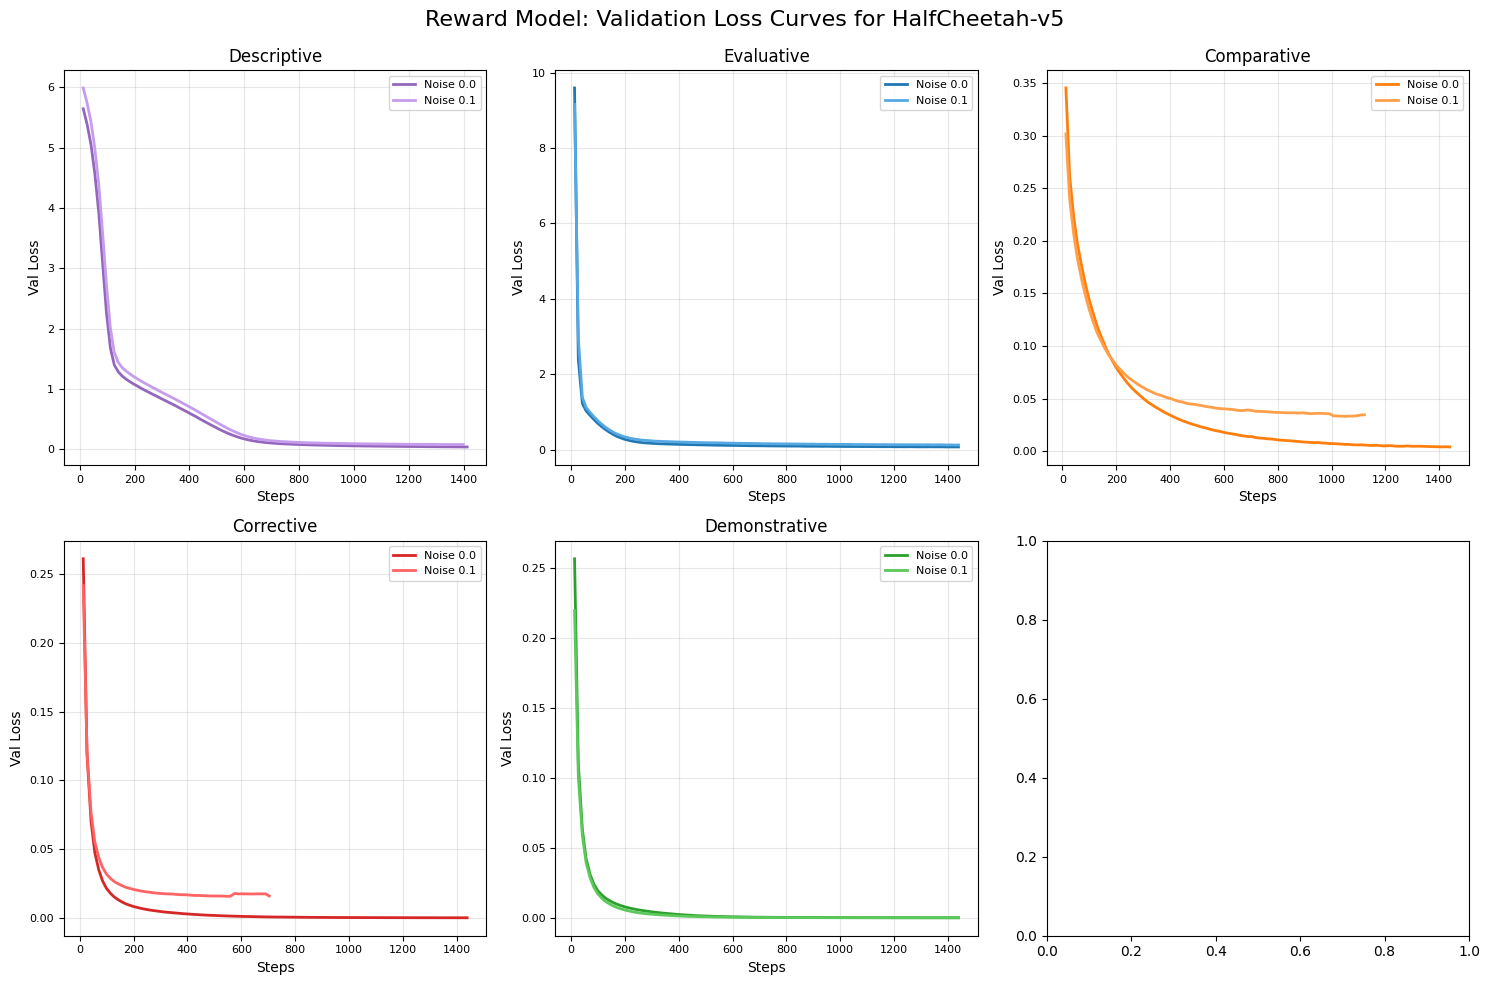

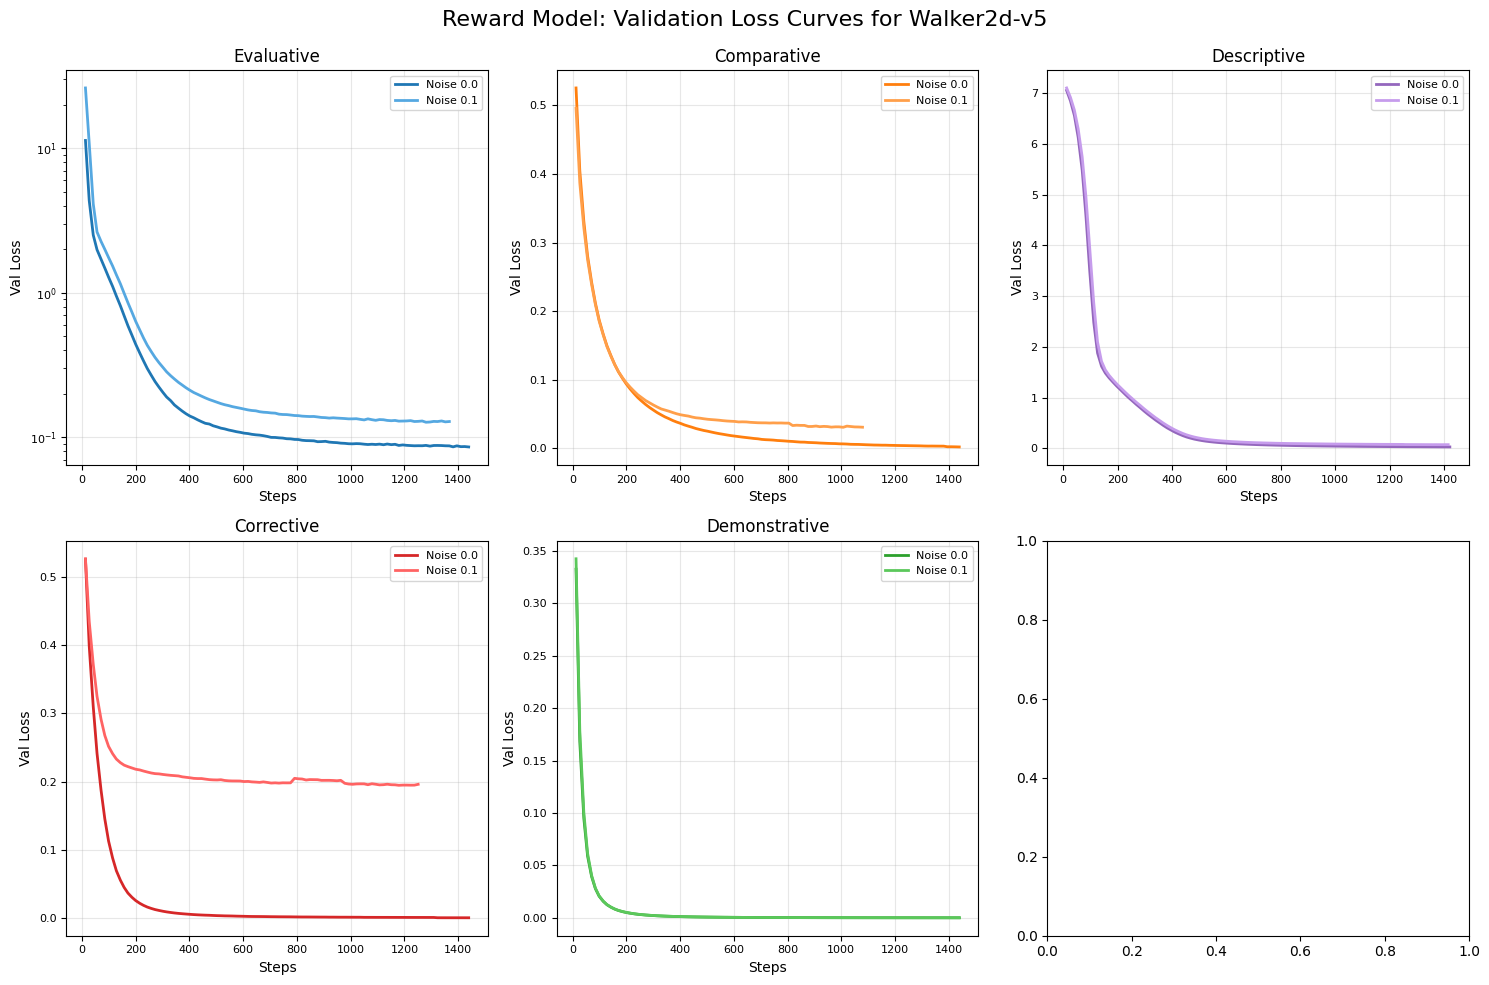

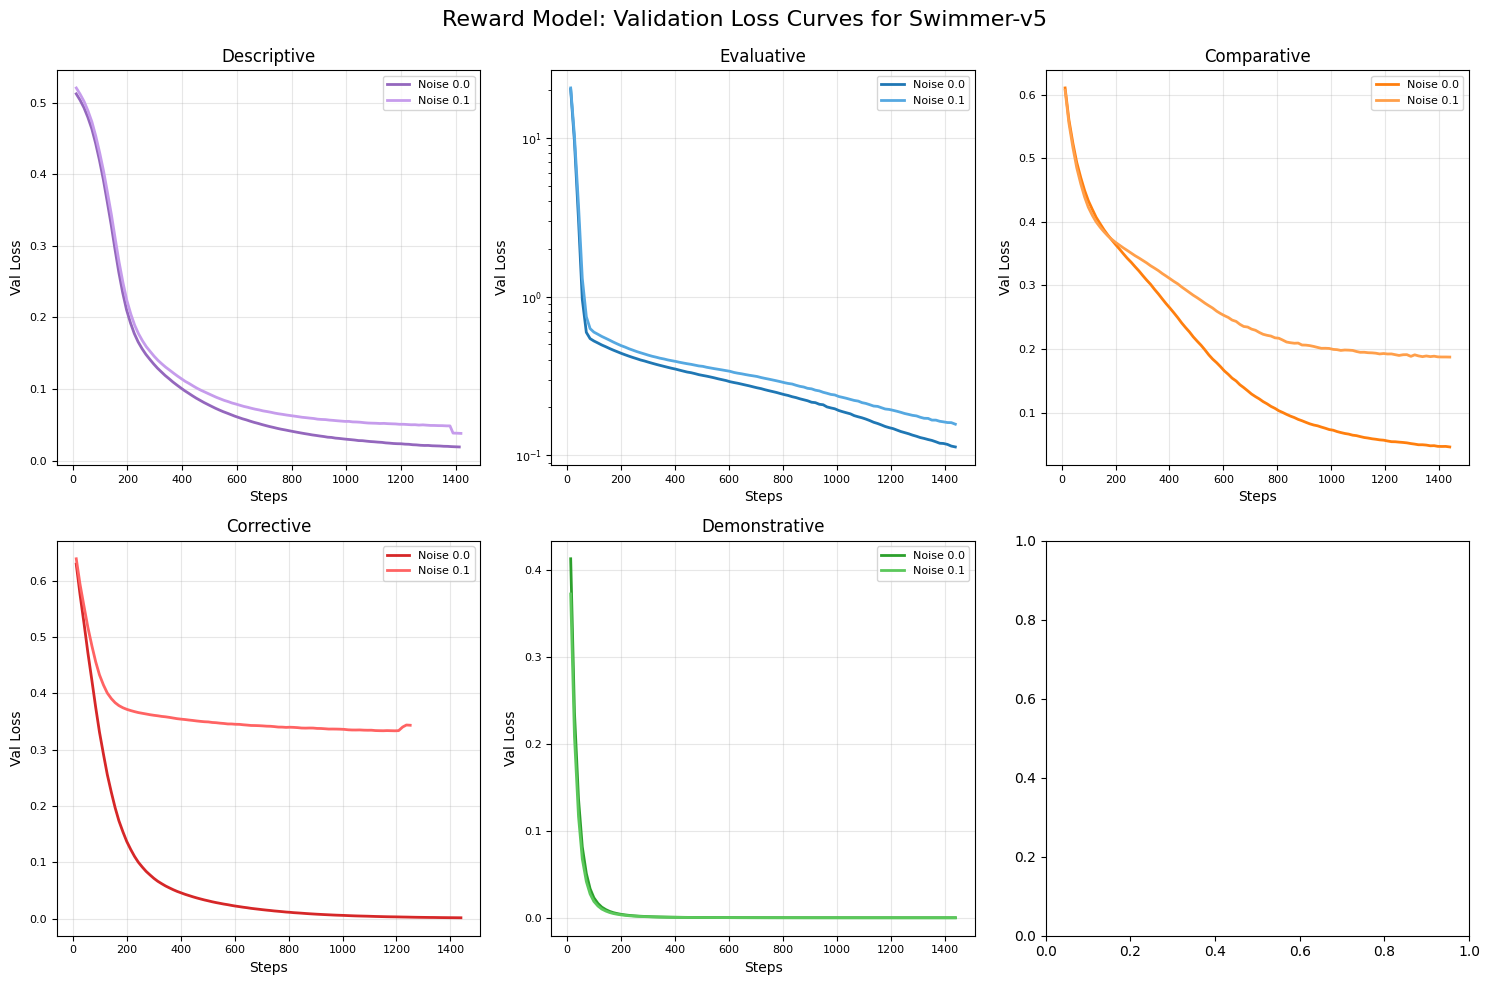

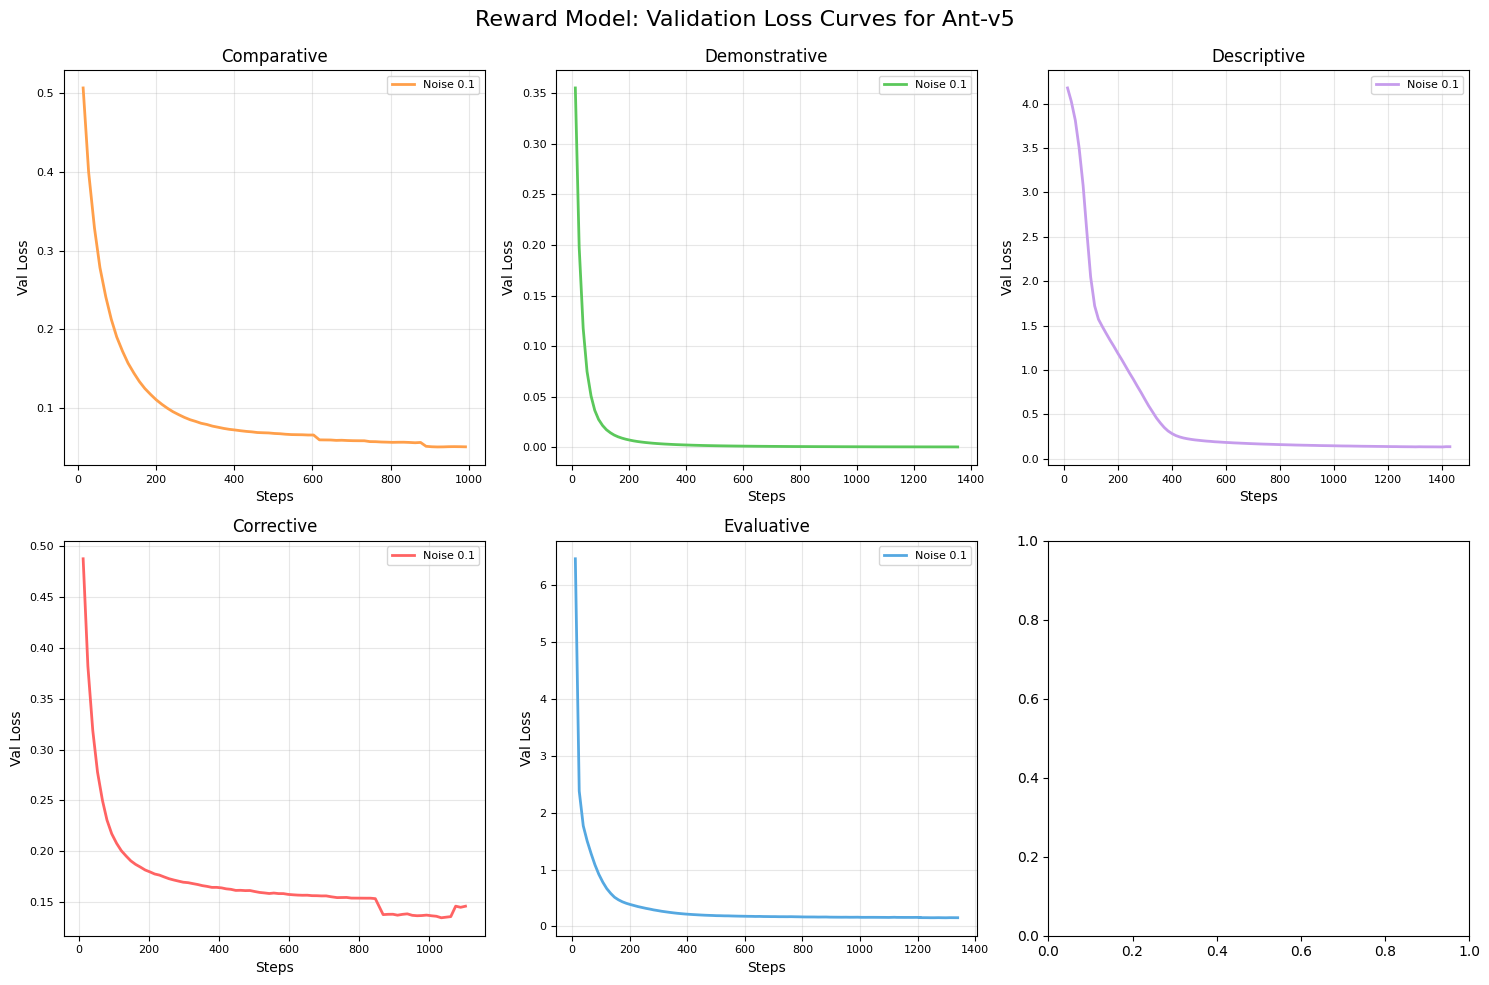

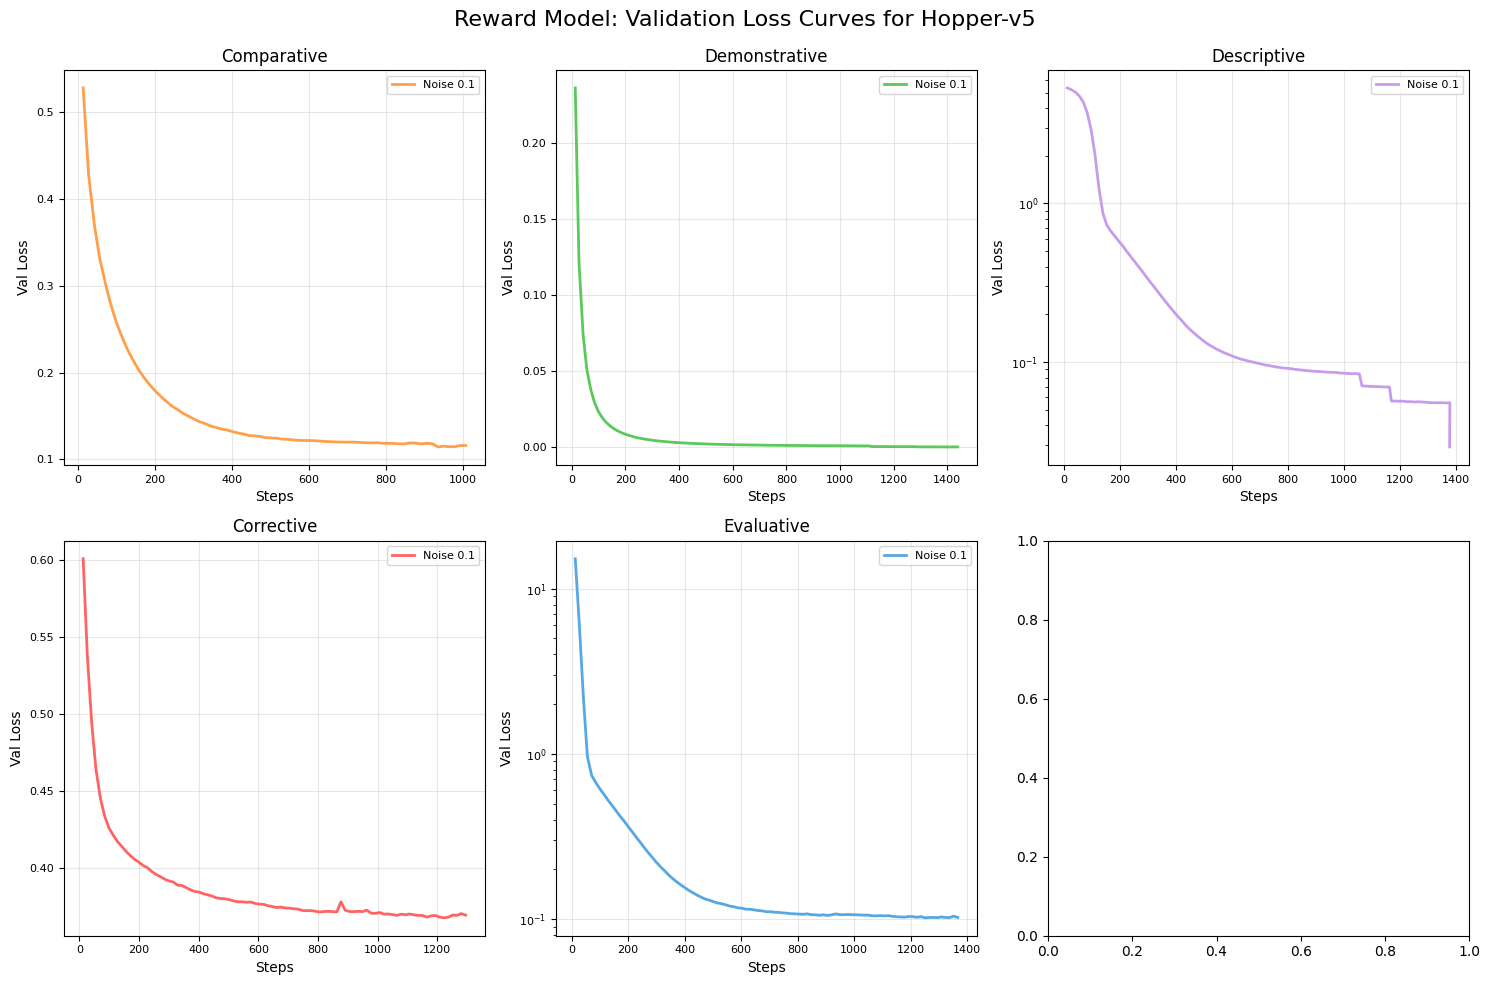

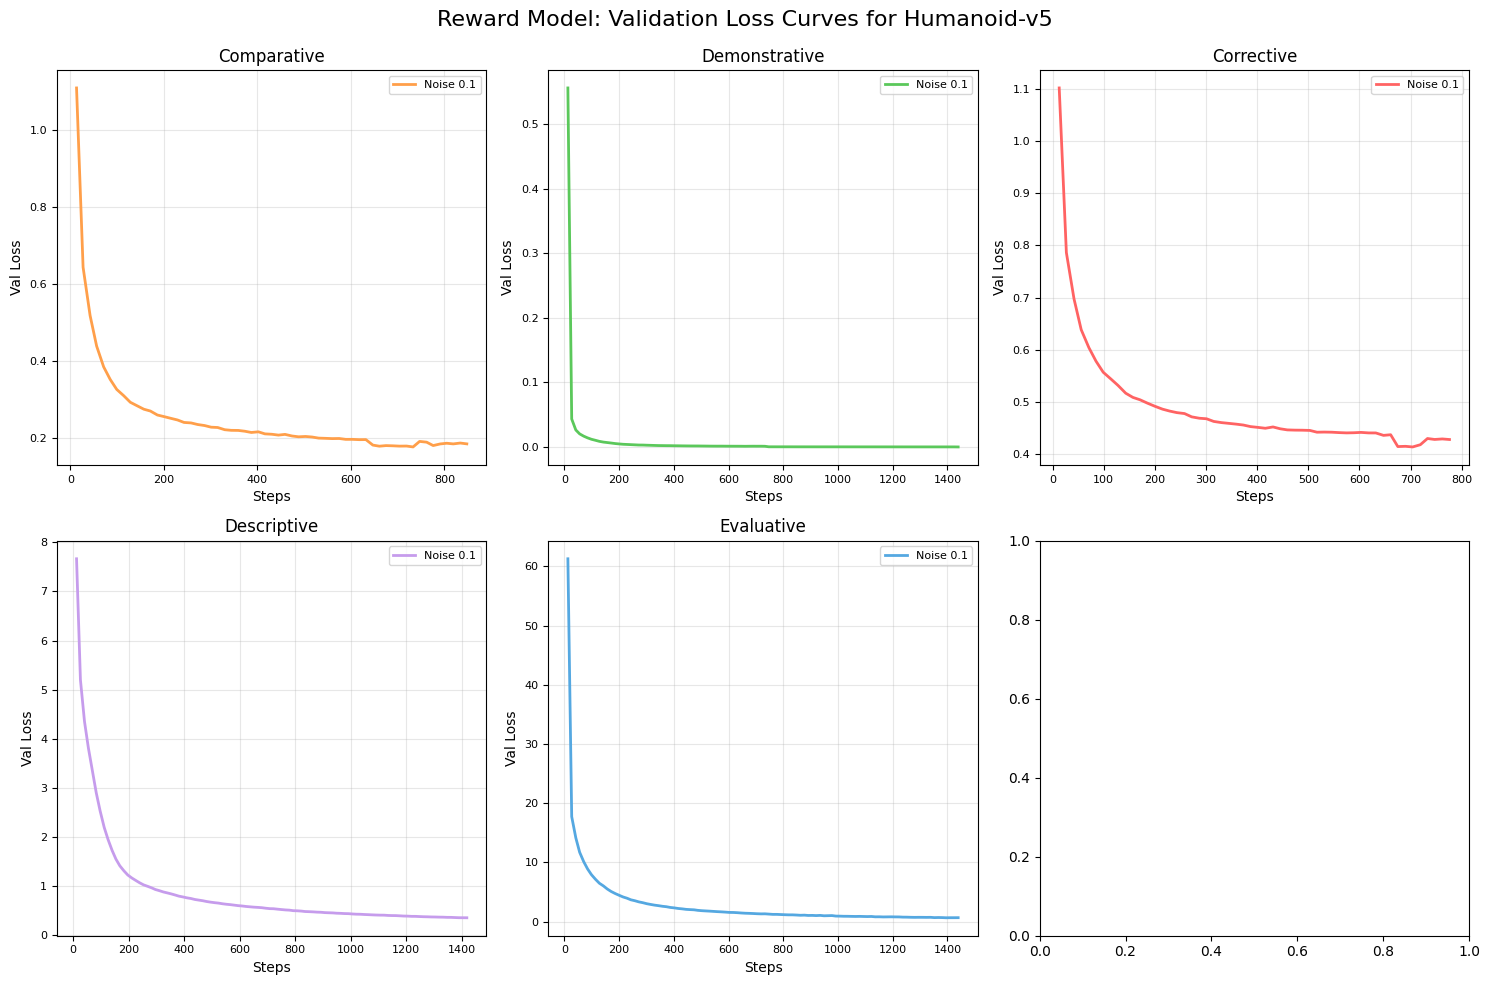

In [3]:
import colorsys
from collections import OrderedDict, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Existing color scale
color_scale = OrderedDict([
    ('evaluative', '#1f77b4'),     # blue
    ('comparative', '#ff7f0e'),    # orange
    ('demonstrative', '#2ca02c'),  # green
    ('corrective', '#d62728'),     # red
    ('descriptive', '#9467bd'),    # purple
    ('preference', '#8c564b'),     # brown
])

# Function to create color variations with stronger fading
def create_color_variations(base_color, num_variations=4):
    rgb = plt.matplotlib.colors.to_rgb(base_color)
    hsv = colorsys.rgb_to_hsv(*rgb)
    colors = []
    for i in range(num_variations):
        # Reduce saturation and increase value (brightness) for higher noise levels
        s = max(0.1, hsv[1] * (1 - i * 0.25))
        v = min(1.0, hsv[2] * (1 + i * 0.25))
        colors.append(colorsys.hsv_to_rgb(hsv[0], s, v))
    return colors

# Function to extract environment, feedback type, and noise level from run name
def extract_info(run_name):
    parts = run_name.split('_')
    env = parts[1]
    feedback = parts[3]
    noise = parts[-1] if parts[-2] == "noise" else "0.0"
    return env, feedback, float(noise)

# Function to interpolate NaN values in a series
def interpolate_nans(series):
    return pd.Series(series).interpolate().ffill().bfill().values

# Group runs by environment, feedback type, and noise level
grouped_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for _, row in df.iterrows():
    env, feedback, noise = extract_info(row['run_name'])
    if isinstance(row['val_loss_history'], float):
        continue
    row['val_loss_history'] = [np.nan if x == "nan" else x for x in row['val_loss_history']]
    row['val_loss_history'] = interpolate_nans(row['val_loss_history'])
    grouped_runs[env][feedback][noise].append(row)

# Plotting function
def plot_environment(env, feedback_runs):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Reward Model: Validation Loss Curves for {env}", fontsize=16)
    
    feedback_types = list(feedback_runs.keys())
    noise_levels = [0.0, 0.1, 0.2, 0.3]
    
    for idx, feedback in enumerate(feedback_types):
        ax = axes[idx // 3, idx % 3]
        base_color = color_scale[feedback]
        color_variations = create_color_variations(base_color)
        
        for noise, color in zip(noise_levels, color_variations):
            if noise not in feedback_runs[feedback]:
                continue
            
            runs = feedback_runs[feedback][noise]
            max_steps = max(len(run['_step_history']) for run in runs)
            all_losses = np.full((len(runs), max_steps), np.nan)
            all_steps = np.full((len(runs), max_steps), np.nan)
            
            for i, run in enumerate(runs):
                length = len(run['_step_history'])
                all_losses[i, :length] = run['val_loss_history']
                all_steps[i, :length] = run['_step_history']
            
            mean_loss = np.nanmean(all_losses, axis=0)
            steps = np.nanmean(all_steps, axis=0)
            
            valid = ~np.isnan(mean_loss)
            steps = steps[valid]
            mean_loss = mean_loss[valid]
            
            ax.plot(steps, mean_loss, label=f"Noise {noise}", color=color, linewidth=2)
        
        ax.set_title(f"{feedback.capitalize()}", fontsize=12)
        ax.set_xlabel("Steps", fontsize=10)
        ax.set_ylabel("Val Loss", fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3)
        
        if feedback in ["evaluative", "descriptive"] and np.nanmax(mean_loss) / np.nanmin(mean_loss[np.isfinite(mean_loss)]) > 100:
            ax.set_yscale('log')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    #plt.savefig(f"loss_curves_{env}.png", dpi=300)
    #plt.close()
    print(f"Loss curves for {env} have been saved to loss_curves_{env}.png")

# Create plots for each environment
for env, feedback_runs in grouped_runs.items():
    plot_environment(env, feedback_runs)

Loss curves for HalfCheetah-v5 have been saved to loss_curves_HalfCheetah-v5.png
Loss curves for Walker2d-v5 have been saved to loss_curves_Walker2d-v5.png
Loss curves for Swimmer-v5 have been saved to loss_curves_Swimmer-v5.png
Loss curves for Ant-v5 have been saved to loss_curves_Ant-v5.png
Loss curves for Hopper-v5 have been saved to loss_curves_Hopper-v5.png
Loss curves for Humanoid-v5 have been saved to loss_curves_Humanoid-v5.png


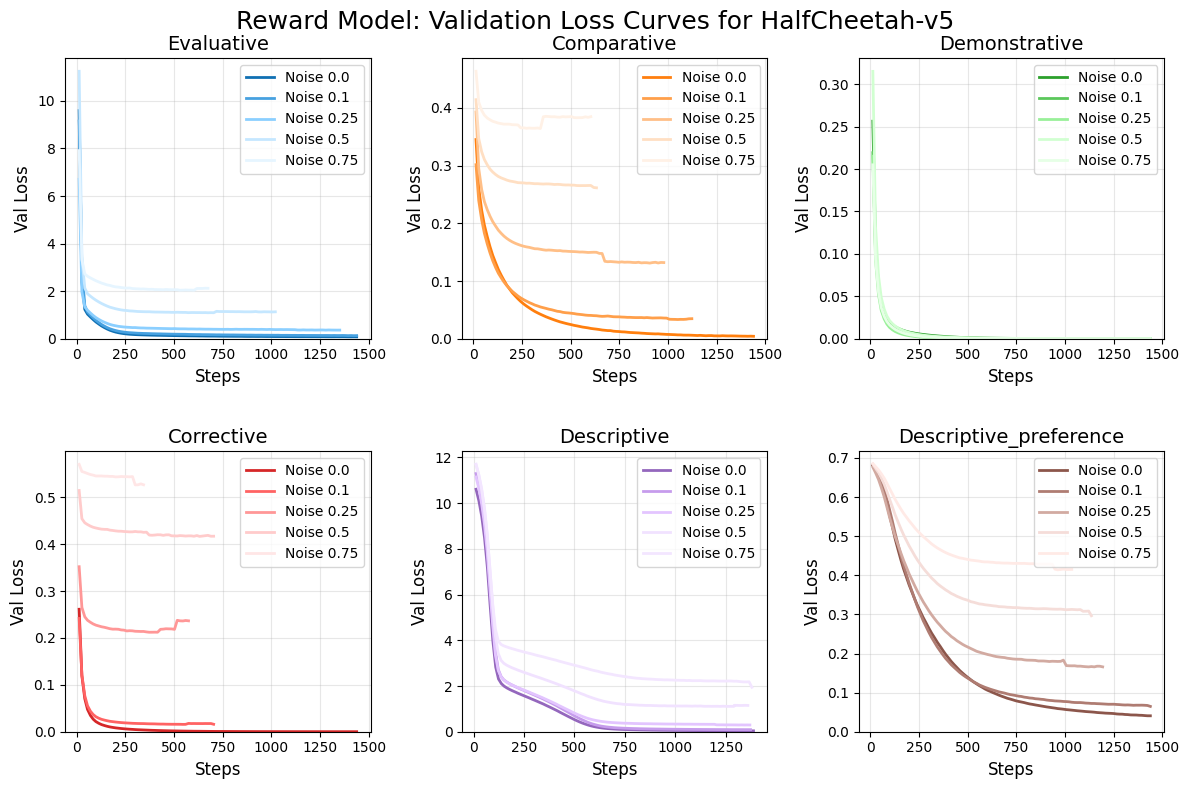

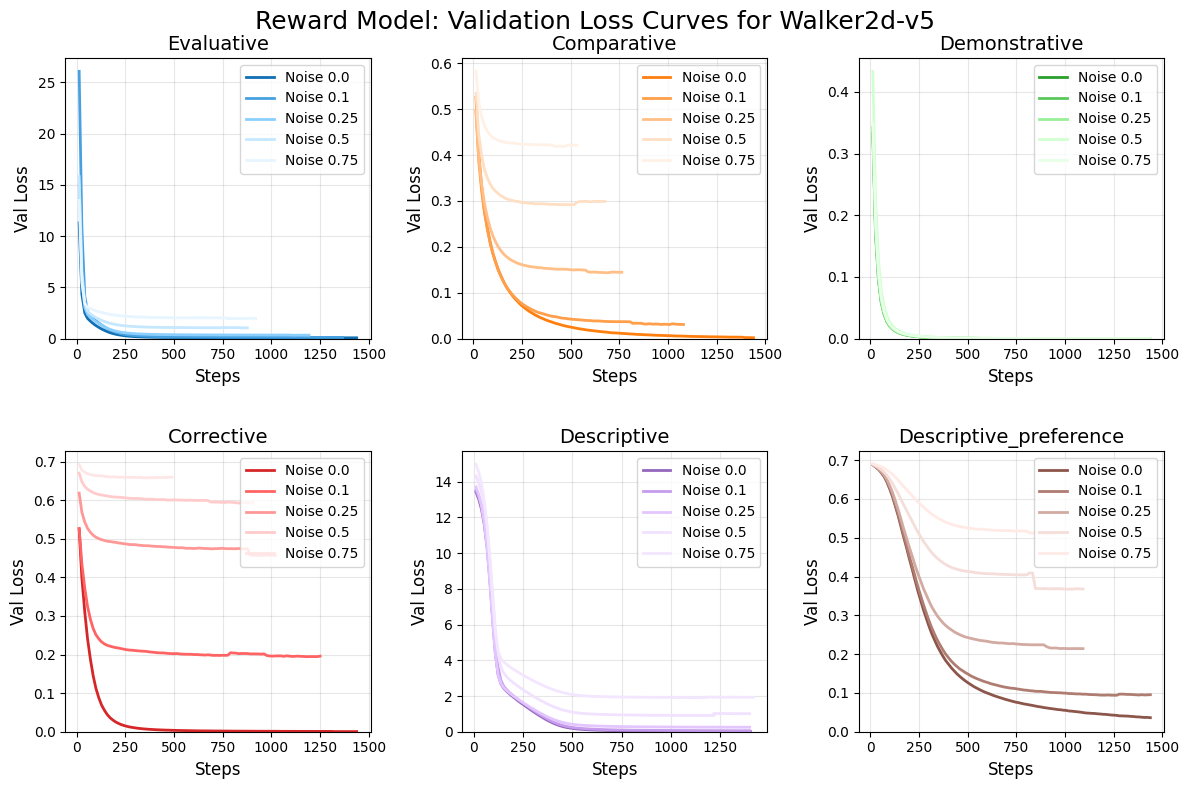

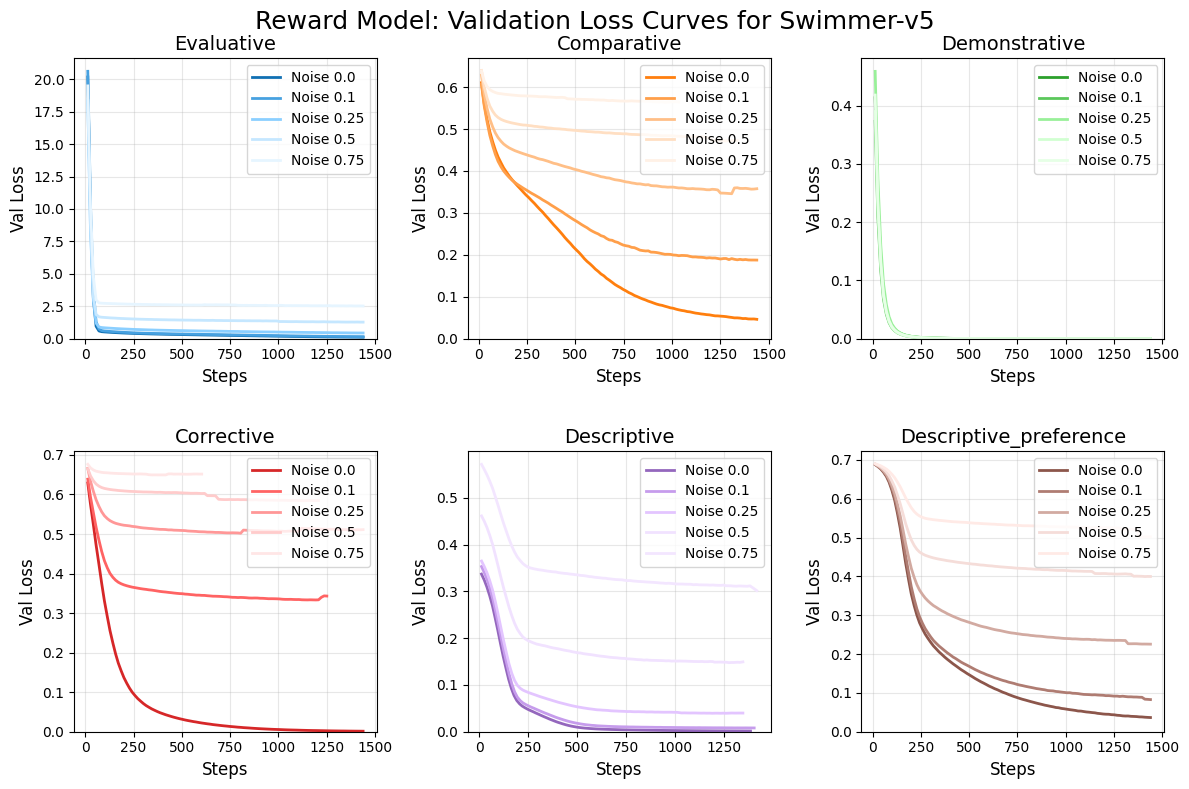

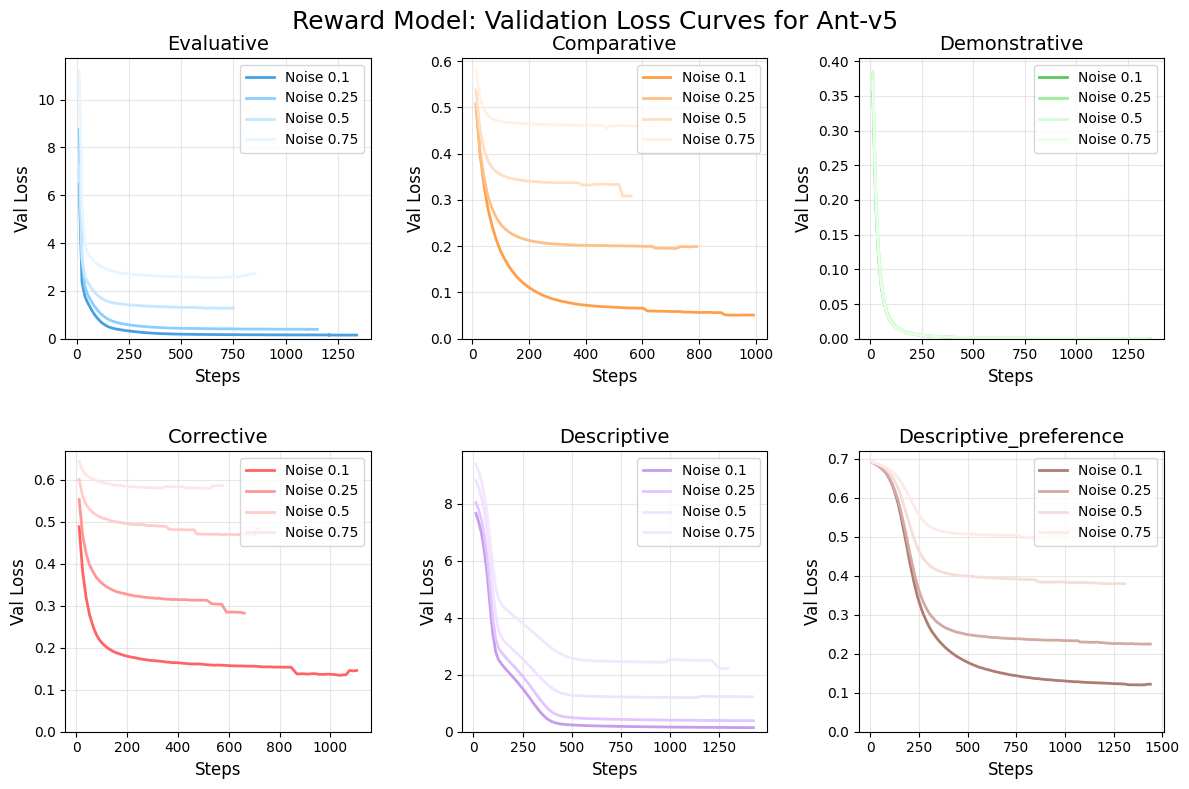

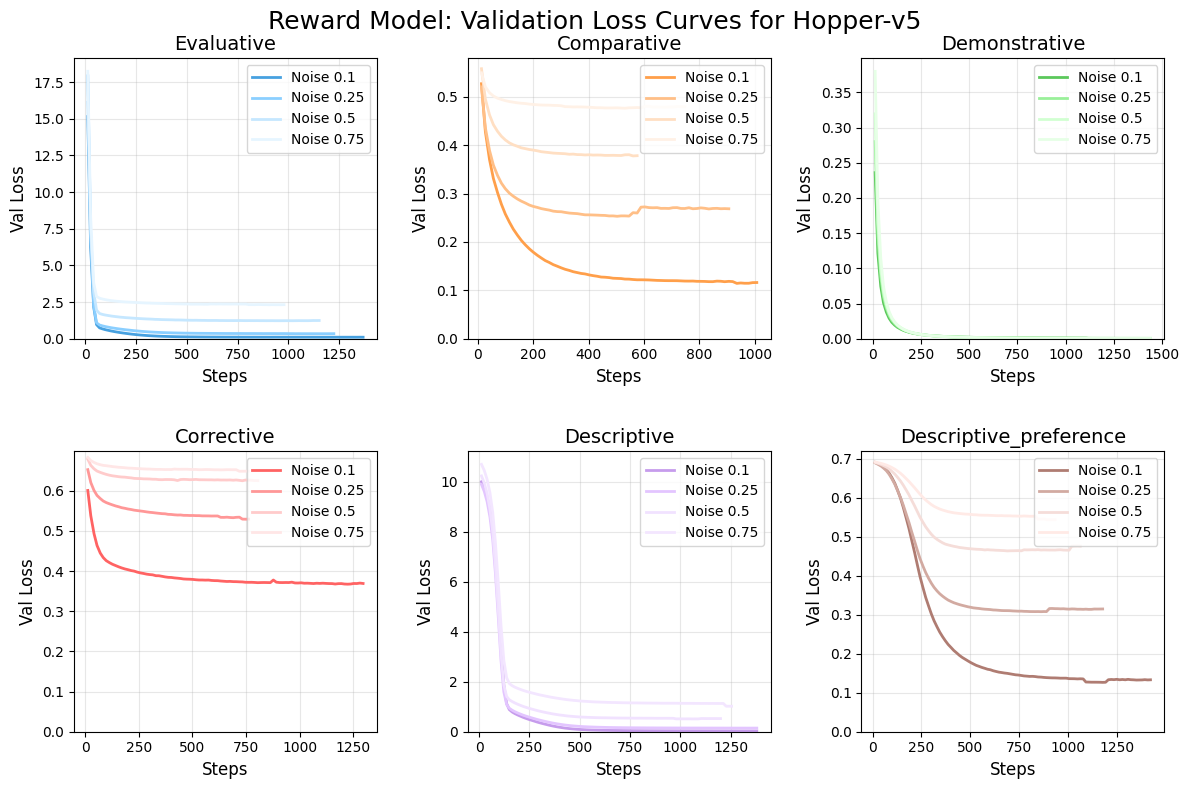

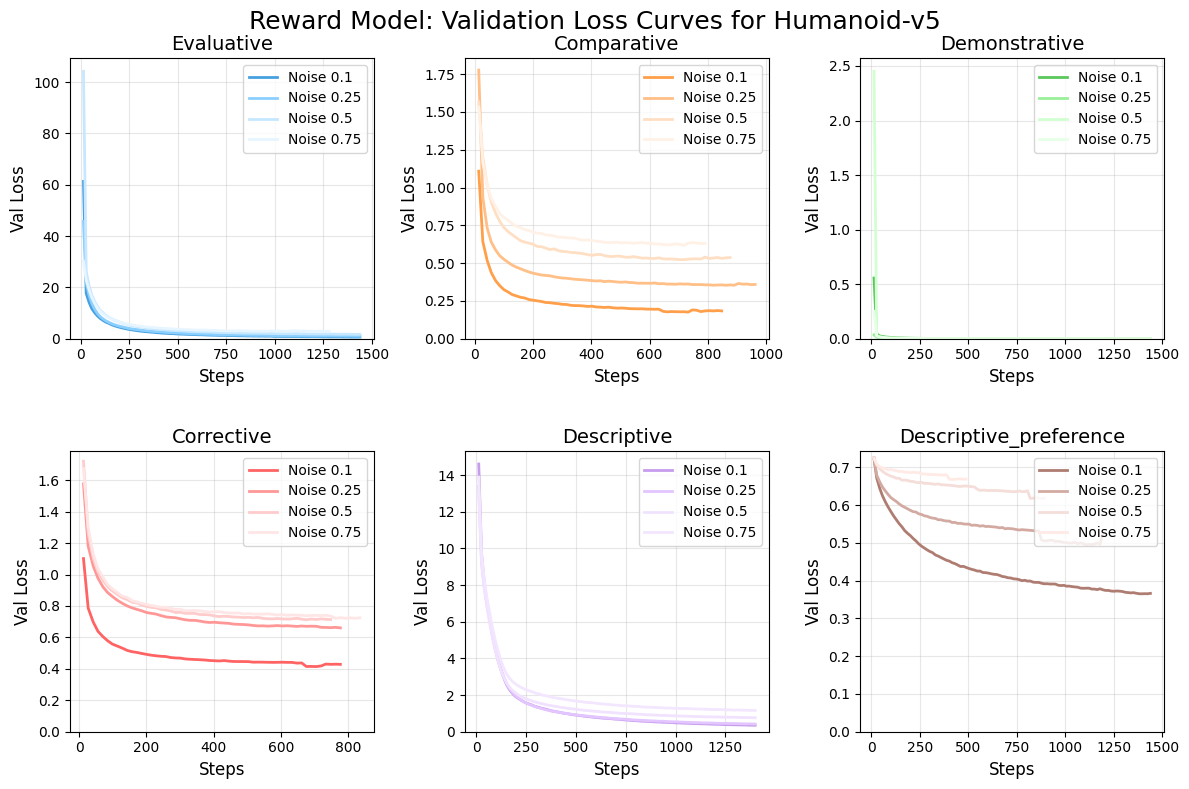

In [4]:
import colorsys
from collections import OrderedDict, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define a color scale for feedback types
color_scale = OrderedDict([
    ('evaluative', '#1070b3'),     # blue
    ('comparative', '#ff7f0e'),    # orange
    ('demonstrative', '#2ca02c'),  # green
    ('corrective', '#d62728'),     # red
    ('descriptive', '#9467bd'),    # purple
    ('descriptive_preference', '#8c564b'),  # brown
])

# Function to create color variations with stronger fading
def create_color_variations(base_color, num_variations=5):
    rgb = plt.matplotlib.colors.to_rgb(base_color)
    hsv = colorsys.rgb_to_hsv(*rgb)
    colors = []
    for i in range(num_variations):
        s = max(0.1, hsv[1] * (1 - i * 0.25))
        v = min(1.0, hsv[2] * (1 + i * 0.25))
        colors.append(colorsys.hsv_to_rgb(hsv[0], s, v))
    return colors

# Function to extract environment, feedback type, and noise level from run name
def extract_info(run_name):
    parts = run_name.split('_')
    env = parts[1]
    
    # Handle the special case of "descriptive_preference"
    if "descriptive_preference" in run_name:
        feedback = "descriptive_preference"
        noise = parts[-1] if parts[-2] == "noise" else "0.0"
    else:
        feedback = parts[3]
        noise = parts[-1] if parts[-2] == "noise" else "0.0"

    return env, feedback, float(noise)

# Function to interpolate NaN values in a series
def interpolate_nans(series):
    return pd.Series(series).interpolate().ffill().bfill().values

# Group runs by environment, feedback type, and noise level
grouped_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for _, row in df.iterrows():
    env, feedback, noise = extract_info(row['run_name'])
    if isinstance(row['val_loss_history'], float):
        continue
    row['val_loss_history'] = [np.nan if x == "nan" else x for x in row['val_loss_history']]
    row['val_loss_history'] = interpolate_nans(row['val_loss_history'])
    grouped_runs[env][feedback][noise].append(row)

# Plotting function
def plot_environment(env, feedback_runs):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Reduced figure size
    fig.suptitle(f"Reward Model: Validation Loss Curves for {env}", fontsize=18)
    
    feedback_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference"]
    noise_levels = [0.0, 0.1, 0.25, 0.5, 0.75]
    
    for idx, feedback in enumerate(feedback_types):
        ax = axes[idx // 3, idx % 3]
        base_color = color_scale[feedback]
        color_variations = create_color_variations(base_color)
        
        for noise, color in zip(noise_levels, color_variations):
            if noise not in feedback_runs[feedback]:
                continue
            
            runs = feedback_runs[feedback][noise]
            max_steps = max(len(run['_step_history']) for run in runs)
            all_losses = np.full((len(runs), max_steps), np.nan)
            all_steps = np.full((len(runs), max_steps), np.nan)
            
            for i, run in enumerate(runs):
                length = len(run['_step_history'])
                all_losses[i, :length] = run['val_loss_history']
                all_steps[i, :length] = run['_step_history']
            
            mean_loss = np.nanmean(all_losses, axis=0)
            steps = np.nanmean(all_steps, axis=0)
            
            valid = ~np.isnan(mean_loss)
            steps = steps[valid]
            mean_loss = mean_loss[valid]
            
            ax.plot(steps, mean_loss, label=f"Noise {noise}", color=color, linewidth=2)
        
        ax.set_title(f"{feedback.capitalize()}", fontsize=14)
        ax.set_xlabel("Steps", fontsize=12)
        ax.set_ylabel("Val Loss", fontsize=12)
        ax.set_ylim(bottom=0)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.legend(fontsize=10, loc='upper right')
        ax.grid(True, alpha=0.3)
        
        if feedback in ["evaluative", "descriptive"] and np.nanmax(mean_loss) / np.nanmin(mean_loss[np.isfinite(mean_loss)]) > 100:
            ax.set_yscale('log')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)  # Adjusted spacing
    plt.savefig(f"noise_loss_curves_{env}.png", dpi=300)
    #plt.close()
    print(f"Loss curves for {env} have been saved to loss_curves_{env}.png")

# Create plots for each environment
for env, feedback_runs in grouped_runs.items():
    plot_environment(env, feedback_runs)